Berceley Deep RL course. Fall 2017
http://rll.berkeley.edu/deeprlcourse/
Homework 1

## Behavioral Cloning
1.  Run  behavioral  cloning  (BC)  and  report  results  on  two  other  tasks  –  one  task  where  a  behavioral
cloning agent achieves comparable performance to the expert, and one task where it does not.  When
providing  results,  report  the  mean  and  standard  deviation  of  the  return  over  multiple  rollouts  in  a
table, and state which task was used.  Be sure to set up a fair comparison, in terms of network size,
amount of data, and number of training iterations, and provide these details (and any others you feel
are appropriate) in the table caption.
1
2.  Experiment with one hyperparameter that affects the performance of the behavioral cloning agent, such
as the number of demonstrations, the number of training epochs, the variance of the expert policy, or
something that you come up with yourself.  For one of the tasks used in the previous question, show a
graph of how the BC agent’s performance varies with the value of this hyperparameter, and state the
hyperparameter and a brief rationale for why you chose it in the caption for the graph.

In [1]:
import gym
 
#env = gym.make('Hopper-v1')

In [2]:
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

### Feed forward nn

In [3]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,output_size,dropout_rate = 0.3):
        super(FFN, self).__init__()
        self.dropout_rate = dropout_rate
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.drop1  = nn.Dropout(p = self.dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.drop2  = nn.Dropout(p = self.dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        x = self.fc3(x)
        return x.view(x.size(0), -1)
    
    def set_dropout_rate(self, p):
        self.dropout_rate = p
        


In [4]:
criterion = torch.nn.L1Loss()

# Training function
def train_ffn(states_tensor, actions_tensor,learning_rate):
    tmp_loss = 0
    
    ffn.zero_grad()

    output = ffn(states_tensor)               # Predict action
    loss = criterion(output, actions_tensor)  # Calculate error
    tmp_loss += loss.data[0]
    loss.backward()                              # Error backpropagation

    for p in ffn.parameters():                   # Update net's parameters
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, tmp_loss 

In [5]:
#!/usr/bin/env python

"""
Code to load an expert policy and generate roll-out data for behavioral cloning.
Example usage:
    python run_expert.py experts/Humanoid-v1.pkl Humanoid-v1 --render \
            --num_rollouts 20

Author of this script and included expert policies: Jonathan Ho (hoj@openai.com)
"""

import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import pandas as pd

minibatch_size = 8

def learn_imitatation_learning(ffn, args):
    
    print('loading and building expert policy')
    target_policy_fn = load_policy.load_policy(args.expert_policy_file)
    print('loaded and built')

    with tf.Session():
        tf_util.initialize()

        import gym
        env = gym.make(args.envname)
        max_steps = args.max_timesteps or env.spec.timestep_limit

        returns = []
        observations = []
        actions = []
        for i in range(args.num_rollouts):
            #print('iter', i)
            obs = env.reset()
            done = False
            totalr = 0.
            steps = 0
            while not done:
                action = target_policy_fn(obs[None,:])
                observations.append(obs)
                actions.append(action)
                obs, r, done, _ = env.step(action)
                totalr += r
                steps += 1
                
                if args.render:
                    env.render()
                if steps % minibatch_size == 0: 
                    _, error = train_ffn(Variable(torch.Tensor(observations[-minibatch_size:])), 
                                         Variable(torch.Tensor(np.array(actions[-minibatch_size:])[:,0,:])),
                                         learning_rate
                                        )
                    #print("%i/%i, Error %f"%(steps, max_steps,error))
                    
                    
                if steps >= max_steps:
                    break
            returns.append(totalr)

#         print('returns', returns)
#         print('mean return', np.mean(returns))
#         print('std of return', np.std(returns))

#         expert_data = {'observations': np.array(observations),
#                        'actions': np.array(actions)}
        return returns,error
        

#Evaluate learned policy
def evaluate_imitation_learning(ffn, args):
    dropout_rate = ffn.dropout_rate
    ffn.dropout_rate = 0
    env = gym.make(args.envname)
    max_steps = args.max_timesteps or env.spec.timestep_limit

    returns = []
    observations = []
    actions = []
    for i in range(args.num_rollouts):
        #print('iter', i)
        obs = env.reset()
        done = False
        totalr = 0.
        steps = 0
        while not done:
            action = ffn(Variable(torch.Tensor(obs))).data.numpy()  
            observations.append(obs)
            actions.append(action)
            obs, r, done, _ = env.step(action)
            totalr += r
            steps += 1

            if args.render:
                env.render()

            if steps >= max_steps:
                break
            
        #print(totalr)
        returns.append(totalr)

#     print('returns', returns)
#     print('mean return', np.mean(returns))
#     print('std of return', np.std(returns))

#     expert_data = {'observations': np.array(observations),
#                    'actions': np.array(actions)}
        ffn.dropout_rate = dropout_rate
        return returns


In [6]:
! ls experts/

Ant-v1.pkl	    Hopper-v1.pkl    Reacher-v1.pkl
HalfCheetah-v1.pkl  Humanoid-v1.pkl  Walker2d-v1.pkl


### Train loop

In [10]:
learning_rate = 1e-2

envname = 'Humanoid-v1'
env = gym.make(envname)
#with gym.make(envname) as env:
state_shape = env.observation_space.shape[0]
actions_shape = env.action_space.shape[0]

print('Starting {} environment. State space dim (), action space dim {}.'.format(
    envname,
    state_shape,
    actions_shape)
     )

ffn = FFN(state_shape, 128, 64,actions_shape,dropout_rate = 0)

learn_args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })


eval_args = pd.Series({
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':2,
        'render': False
    })

n_iter = 300

results = []
for i in range(n_iter):
    experts_returns, error = learn_imitatation_learning(ffn, learn_args)
    agent_returns   = evaluate_imitation_learning(ffn, eval_args)
    print(i, np.mean(experts_returns),np.mean(error), np.mean(agent_returns),np.std(agent_returns))
    results.append((np.mean(experts_returns),np.mean(error),np.mean(agent_returns),np.std(agent_returns)))


[2017-11-02 16:20:58,409] Making new env: Humanoid-v1


Starting Humanoid-v1 environment. State space dim (), action space dim 376.
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:20:58,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:20:58,828] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:20:59,730] Making new env: Humanoid-v1
[2017-11-02 16:21:15,390] Making new env: Humanoid-v1


0 10376.4688014 0.584160745144 184.246511565 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:15,828] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:15,849] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:16,615] Making new env: Humanoid-v1
[2017-11-02 16:21:34,937] Making new env: Humanoid-v1


1 10394.6091865 0.624385535717 174.117419847 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:35,406] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:35,428] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:36,141] Making new env: Humanoid-v1
[2017-11-02 16:21:54,821] Making new env: Humanoid-v1


2 10392.2338716 0.345888644457 158.353395588 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:21:55,248] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:21:55,267] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:21:55,849] Making new env: Humanoid-v1
[2017-11-02 16:22:15,138] Making new env: Humanoid-v1


3 10457.9717862 0.51638174057 258.327328596 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:15,821] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:15,837] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:16,409] Making new env: Humanoid-v1
[2017-11-02 16:22:34,015] Making new env: Humanoid-v1


4 10420.8276779 0.526348590851 135.332298615 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:34,332] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:34,351] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:35,148] Making new env: Humanoid-v1
[2017-11-02 16:22:53,620] Making new env: Humanoid-v1


5 10445.1924317 0.441075116396 455.125961729 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:22:54,552] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:22:54,569] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:22:55,097] Making new env: Humanoid-v1
[2017-11-02 16:23:09,909] Making new env: Humanoid-v1


6 10376.7886926 0.325895577669 375.934514118 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:10,532] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:10,549] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:11,057] Making new env: Humanoid-v1
[2017-11-02 16:23:24,730] Making new env: Humanoid-v1


7 10389.1311555 0.394975244999 161.556594359 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:25,038] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:25,057] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:25,633] Making new env: Humanoid-v1
[2017-11-02 16:23:39,504] Making new env: Humanoid-v1


8 10430.8209221 0.325839877129 169.020567176 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:39,805] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:39,825] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:40,336] Making new env: Humanoid-v1
[2017-11-02 16:23:56,043] Making new env: Humanoid-v1


9 10426.0752754 0.596417605877 155.179608619 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:23:56,363] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:23:56,384] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:23:56,930] Making new env: Humanoid-v1
[2017-11-02 16:24:14,134] Making new env: Humanoid-v1


10 10352.7189685 0.381718754768 155.038291783 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:14,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:14,505] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:15,095] Making new env: Humanoid-v1
[2017-11-02 16:24:31,331] Making new env: Humanoid-v1


11 10431.3524955 0.229115456343 145.303428398 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:31,687] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:31,703] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:32,334] Making new env: Humanoid-v1
[2017-11-02 16:24:49,269] Making new env: Humanoid-v1


12 10427.7560325 0.278926759958 511.4732306 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:24:50,358] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:24:50,375] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:24:50,945] Making new env: Humanoid-v1
[2017-11-02 16:25:07,918] Making new env: Humanoid-v1


13 10462.3805194 0.281196624041 145.332785512 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:08,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:08,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:08,921] Making new env: Humanoid-v1
[2017-11-02 16:25:28,187] Making new env: Humanoid-v1


14 10401.5310743 0.34864616394 167.631517807 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:28,643] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:28,660] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:29,297] Making new env: Humanoid-v1
[2017-11-02 16:25:49,383] Making new env: Humanoid-v1


15 10442.529891 0.264762938023 168.044420724 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:25:49,782] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:25:49,800] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:25:50,545] Making new env: Humanoid-v1
[2017-11-02 16:26:10,873] Making new env: Humanoid-v1


16 10350.6490259 0.402575016022 148.444410377 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:11,268] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:11,293] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:12,019] Making new env: Humanoid-v1
[2017-11-02 16:26:31,498] Making new env: Humanoid-v1


17 10362.398596 0.297157883644 148.090156664 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:31,896] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:31,917] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:32,663] Making new env: Humanoid-v1
[2017-11-02 16:26:52,646] Making new env: Humanoid-v1


18 10405.6297261 0.323288619518 162.377455314 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:26:53,073] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:26:53,095] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:26:53,833] Making new env: Humanoid-v1
[2017-11-02 16:27:06,092] Making new env: Humanoid-v1


19 6146.63797099 0.668729364872 498.345942482 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:07,155] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:07,177] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:07,922] Making new env: Humanoid-v1
[2017-11-02 16:27:27,832] Making new env: Humanoid-v1


20 10391.8697063 0.274890512228 133.331234516 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:28,214] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:28,234] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:28,982] Making new env: Humanoid-v1
[2017-11-02 16:27:48,767] Making new env: Humanoid-v1


21 10393.5166806 0.210291042924 146.346612596 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:27:49,162] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:27:49,183] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:27:49,925] Making new env: Humanoid-v1
[2017-11-02 16:28:10,884] Making new env: Humanoid-v1


22 10362.657261 0.277686953545 136.398773903 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:11,269] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:11,296] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:12,051] Making new env: Humanoid-v1
[2017-11-02 16:28:31,215] Making new env: Humanoid-v1


23 10388.2688156 0.289020985365 150.3542243 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:31,633] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:31,651] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:32,420] Making new env: Humanoid-v1
[2017-11-02 16:28:52,355] Making new env: Humanoid-v1


24 10476.5931942 0.327005088329 145.14298383 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:28:52,748] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:28:52,766] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:28:53,516] Making new env: Humanoid-v1
[2017-11-02 16:29:12,395] Making new env: Humanoid-v1


25 10319.7730104 0.273734658957 157.667672324 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:12,877] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:12,903] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:13,855] Making new env: Humanoid-v1
[2017-11-02 16:29:33,031] Making new env: Humanoid-v1


26 10391.2664038 0.235352516174 136.672301951 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:33,425] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:33,447] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:34,233] Making new env: Humanoid-v1
[2017-11-02 16:29:54,522] Making new env: Humanoid-v1


27 10460.357003 0.276594609022 137.606739985 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:29:55,002] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:29:55,016] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:29:55,819] Making new env: Humanoid-v1
[2017-11-02 16:30:15,399] Making new env: Humanoid-v1


28 10473.4183992 0.250345528126 139.790633237 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:15,771] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:15,795] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:16,580] Making new env: Humanoid-v1
[2017-11-02 16:30:36,200] Making new env: Humanoid-v1


29 10426.6692547 0.32212010026 143.46330524 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:30:36,597] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:30:36,617] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:30:37,402] Making new env: Humanoid-v1
[2017-11-02 16:31:02,358] Making new env: Humanoid-v1


30 10416.0010821 0.248448088765 140.479696039 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:02,857] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:02,882] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:03,908] Making new env: Humanoid-v1
[2017-11-02 16:31:28,333] Making new env: Humanoid-v1


31 10443.9825056 0.225417405367 139.959309513 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:28,816] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:28,843] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:29,862] Making new env: Humanoid-v1
[2017-11-02 16:31:55,956] Making new env: Humanoid-v1


32 10423.7794703 0.257195144892 130.574722592 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:31:56,581] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:31:56,605] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:31:57,854] Making new env: Humanoid-v1
[2017-11-02 16:32:23,944] Making new env: Humanoid-v1


33 10421.2976549 0.221497803926 123.053720499 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:24,417] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:24,440] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:25,486] Making new env: Humanoid-v1
[2017-11-02 16:32:51,534] Making new env: Humanoid-v1


34 10396.2105274 0.190735295415 146.702934545 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:32:52,065] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:32:52,089] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:32:53,160] Making new env: Humanoid-v1
[2017-11-02 16:33:18,744] Making new env: Humanoid-v1


35 10435.3881135 0.237156957388 144.857299992 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:19,289] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:19,312] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:20,358] Making new env: Humanoid-v1
[2017-11-02 16:33:45,224] Making new env: Humanoid-v1


36 10432.2610589 0.266369074583 138.136026093 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:33:45,820] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:33:45,845] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:33:47,078] Making new env: Humanoid-v1
[2017-11-02 16:34:12,976] Making new env: Humanoid-v1


37 10466.8491924 0.472721338272 135.526796063 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:13,509] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:13,525] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:14,630] Making new env: Humanoid-v1
[2017-11-02 16:34:40,284] Making new env: Humanoid-v1


38 10433.106934 0.198673263192 142.012486059 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:34:40,813] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:34:40,840] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:34:41,926] Making new env: Humanoid-v1
[2017-11-02 16:35:06,226] Making new env: Humanoid-v1


39 10449.5915299 0.250490874052 145.207931153 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:06,789] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:06,809] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:07,766] Making new env: Humanoid-v1
[2017-11-02 16:35:30,636] Making new env: Humanoid-v1


40 10439.6291395 0.302454560995 148.721446754 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:31,124] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:31,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:32,157] Making new env: Humanoid-v1
[2017-11-02 16:35:57,330] Making new env: Humanoid-v1


41 10458.6374799 0.345064401627 154.129228287 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:35:57,814] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:35:57,831] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:35:58,848] Making new env: Humanoid-v1
[2017-11-02 16:36:22,620] Making new env: Humanoid-v1


42 10465.9572552 0.347813010216 132.115482262 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:23,095] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:23,119] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:24,061] Making new env: Humanoid-v1
[2017-11-02 16:36:46,963] Making new env: Humanoid-v1


43 10368.2341342 0.556073606014 159.342632419 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:36:47,454] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:36:47,470] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:36:48,460] Making new env: Humanoid-v1
[2017-11-02 16:37:10,583] Making new env: Humanoid-v1


44 10431.5797301 0.256218582392 123.57377475 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:11,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:11,085] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:12,171] Making new env: Humanoid-v1
[2017-11-02 16:37:34,585] Making new env: Humanoid-v1


45 10300.6443644 0.256708353758 119.751751756 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:35,045] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:35,070] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:37:36,054] Making new env: Humanoid-v1
[2017-11-02 16:37:59,423] Making new env: Humanoid-v1


46 10390.4814551 0.393544048071 147.818528979 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:37:59,852] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:37:59,869] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:00,911] Making new env: Humanoid-v1
[2017-11-02 16:38:25,807] Making new env: Humanoid-v1


47 10423.0451754 0.210415005684 145.098970491 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:26,310] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:26,335] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:27,351] Making new env: Humanoid-v1
[2017-11-02 16:38:51,126] Making new env: Humanoid-v1


48 10403.8424808 0.275397717953 145.985157615 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:38:51,657] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:38:51,681] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:38:52,816] Making new env: Humanoid-v1
[2017-11-02 16:39:16,255] Making new env: Humanoid-v1


49 10429.3116938 0.203150391579 135.293079845 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:16,733] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:16,753] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:17,754] Making new env: Humanoid-v1
[2017-11-02 16:39:41,167] Making new env: Humanoid-v1


50 10427.4716467 0.246561869979 78.2013075519 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:39:41,470] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:39:41,493] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:39:42,595] Making new env: Humanoid-v1
[2017-11-02 16:40:07,295] Making new env: Humanoid-v1


51 10403.9758791 0.266958206892 133.878507187 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:07,789] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:07,808] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:08,824] Making new env: Humanoid-v1
[2017-11-02 16:40:33,443] Making new env: Humanoid-v1


52 10416.2312347 0.251550972462 148.651515991 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:33,957] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:33,980] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:40:35,319] Making new env: Humanoid-v1
[2017-11-02 16:40:59,039] Making new env: Humanoid-v1


53 10431.3764015 0.235414281487 136.835451973 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:40:59,577] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:40:59,605] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:00,659] Making new env: Humanoid-v1
[2017-11-02 16:41:23,822] Making new env: Humanoid-v1


54 10394.4211069 0.191041603684 136.547715573 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:24,268] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:24,292] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:25,360] Making new env: Humanoid-v1
[2017-11-02 16:41:49,927] Making new env: Humanoid-v1


55 10407.5199369 0.275290250778 166.304014804 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:41:50,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:41:50,441] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:41:51,520] Making new env: Humanoid-v1
[2017-11-02 16:42:15,075] Making new env: Humanoid-v1


56 10454.9899736 0.229926198721 78.8208135052 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:15,431] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:15,450] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:16,497] Making new env: Humanoid-v1
[2017-11-02 16:42:40,299] Making new env: Humanoid-v1


57 10463.271512 0.220440298319 158.987027732 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:42:40,822] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:42:40,848] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:42:41,941] Making new env: Humanoid-v1
[2017-11-02 16:43:05,319] Making new env: Humanoid-v1


58 10398.0748406 0.244304716587 167.237256073 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:05,824] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:05,847] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:06,969] Making new env: Humanoid-v1
[2017-11-02 16:43:30,326] Making new env: Humanoid-v1


59 10423.8847734 0.287963330746 76.8768642952 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:30,692] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:30,716] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:31,807] Making new env: Humanoid-v1
[2017-11-02 16:43:56,141] Making new env: Humanoid-v1


60 10387.5946955 0.164541825652 149.658516917 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:43:56,706] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:43:56,733] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:43:57,860] Making new env: Humanoid-v1
[2017-11-02 16:44:21,384] Making new env: Humanoid-v1


61 10348.36717 0.382020205259 146.40365091 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:21,821] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:21,848] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:22,991] Making new env: Humanoid-v1
[2017-11-02 16:44:48,443] Making new env: Humanoid-v1


62 10347.072737 0.231811881065 134.351099063 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:44:48,877] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:44:48,905] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:44:49,964] Making new env: Humanoid-v1
[2017-11-02 16:45:13,396] Making new env: Humanoid-v1


63 10396.7779819 0.444947481155 147.73263012 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:13,930] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:13,950] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:15,633] Making new env: Humanoid-v1
[2017-11-02 16:45:39,146] Making new env: Humanoid-v1


64 10361.6620289 0.266260743141 143.084363809 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:45:39,674] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:45:39,696] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:45:40,951] Making new env: Humanoid-v1
[2017-11-02 16:46:05,774] Making new env: Humanoid-v1


65 10462.9974339 0.25322291255 122.523146297 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:06,210] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:06,229] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:07,355] Making new env: Humanoid-v1
[2017-11-02 16:46:30,583] Making new env: Humanoid-v1


66 10364.7542263 0.247223943472 127.576842371 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:31,057] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:31,073] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:32,220] Making new env: Humanoid-v1
[2017-11-02 16:46:56,010] Making new env: Humanoid-v1


67 10421.3251074 0.364769339561 151.116510372 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:46:56,538] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:46:56,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:46:57,655] Making new env: Humanoid-v1
[2017-11-02 16:47:21,057] Making new env: Humanoid-v1


68 10376.6120009 0.231477349997 141.064383499 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:21,490] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:21,512] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:22,713] Making new env: Humanoid-v1
[2017-11-02 16:47:46,585] Making new env: Humanoid-v1


69 10436.6583236 0.237065568566 142.057190059 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:47:47,153] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:47:47,170] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:47:48,511] Making new env: Humanoid-v1
[2017-11-02 16:48:12,828] Making new env: Humanoid-v1


70 10415.389107 0.299797266722 144.51447641 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:13,322] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:13,345] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:14,466] Making new env: Humanoid-v1
[2017-11-02 16:48:38,345] Making new env: Humanoid-v1


71 10333.4104143 0.163934797049 155.507721837 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:48:38,849] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:48:38,877] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:48:40,063] Making new env: Humanoid-v1
[2017-11-02 16:49:04,183] Making new env: Humanoid-v1


72 10364.2229437 0.299133658409 148.950133945 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:04,621] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:04,642] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:05,473] Making new env: Humanoid-v1
[2017-11-02 16:49:22,564] Making new env: Humanoid-v1


73 10371.4261411 0.292056143284 161.309497499 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:22,973] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:22,988] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:23,943] Making new env: Humanoid-v1
[2017-11-02 16:49:40,751] Making new env: Humanoid-v1


74 10441.4543078 0.236080810428 102.123609923 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:49:41,078] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:49:41,093] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:49:41,953] Making new env: Humanoid-v1
[2017-11-02 16:50:00,583] Making new env: Humanoid-v1


75 10365.7757675 0.250873833895 158.889785275 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:01,011] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:01,048] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:01,917] Making new env: Humanoid-v1
[2017-11-02 16:50:19,191] Making new env: Humanoid-v1


76 10347.4960846 0.209301158786 143.774553327 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:19,583] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:19,599] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:20,463] Making new env: Humanoid-v1
[2017-11-02 16:50:38,240] Making new env: Humanoid-v1


77 10369.9265619 0.192277610302 121.593952952 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:38,601] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:38,623] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:39,521] Making new env: Humanoid-v1
[2017-11-02 16:50:56,510] Making new env: Humanoid-v1


78 10439.6230903 0.260647028685 179.858614954 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:50:56,992] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:50:57,009] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:50:57,859] Making new env: Humanoid-v1
[2017-11-02 16:51:15,361] Making new env: Humanoid-v1


79 10378.585278 0.340557426214 144.390018871 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:15,764] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:15,788] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:16,705] Making new env: Humanoid-v1
[2017-11-02 16:51:34,279] Making new env: Humanoid-v1


80 10412.1669385 0.198809921741 151.012460367 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:34,649] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:34,666] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:35,663] Making new env: Humanoid-v1
[2017-11-02 16:51:54,264] Making new env: Humanoid-v1


81 10410.0283697 0.271908372641 164.77704954 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:51:54,740] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:51:54,752] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:51:55,931] Making new env: Humanoid-v1
[2017-11-02 16:52:13,447] Making new env: Humanoid-v1


82 10384.6039809 0.285327732563 172.724333982 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:13,899] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:13,916] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:14,863] Making new env: Humanoid-v1
[2017-11-02 16:52:32,394] Making new env: Humanoid-v1


83 10360.1375387 0.259681254625 144.402003775 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:32,747] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:32,762] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:33,735] Making new env: Humanoid-v1
[2017-11-02 16:52:53,746] Making new env: Humanoid-v1


84 10385.1740523 0.330543845892 217.624232117 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:52:54,302] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:52:54,319] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:52:55,443] Making new env: Humanoid-v1
[2017-11-02 16:53:14,454] Making new env: Humanoid-v1


85 10377.4387631 0.269159018993 164.00058116 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:14,875] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:14,900] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:15,815] Making new env: Humanoid-v1
[2017-11-02 16:53:33,271] Making new env: Humanoid-v1


86 10468.7643358 0.258824080229 144.077398683 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:33,577] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:33,594] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:34,575] Making new env: Humanoid-v1
[2017-11-02 16:53:52,711] Making new env: Humanoid-v1


87 10414.0340425 0.347910314798 126.039332461 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:53:53,110] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:53:53,124] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:53:54,078] Making new env: Humanoid-v1
[2017-11-02 16:54:11,815] Making new env: Humanoid-v1


88 10401.486494 0.313256800175 149.39651431 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:12,131] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:12,146] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:13,237] Making new env: Humanoid-v1
[2017-11-02 16:54:31,584] Making new env: Humanoid-v1


89 10409.9086964 0.209328860044 159.568578312 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:31,945] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:31,961] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:32,917] Making new env: Humanoid-v1
[2017-11-02 16:54:50,649] Making new env: Humanoid-v1


90 10371.46122 0.308642834425 135.719858837 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:54:51,044] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:54:51,064] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:54:51,946] Making new env: Humanoid-v1
[2017-11-02 16:55:08,767] Making new env: Humanoid-v1


91 10453.7463291 0.254320770502 154.537948399 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:09,127] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:09,154] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:10,079] Making new env: Humanoid-v1
[2017-11-02 16:55:27,279] Making new env: Humanoid-v1


92 10467.2946028 0.18883445859 152.167310964 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:27,702] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:27,723] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:28,752] Making new env: Humanoid-v1
[2017-11-02 16:55:45,812] Making new env: Humanoid-v1


93 10305.3887591 0.179310068488 146.575399686 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:55:46,236] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:55:46,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:55:47,351] Making new env: Humanoid-v1
[2017-11-02 16:56:06,027] Making new env: Humanoid-v1


94 10485.3605485 0.223950192332 151.838357548 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:06,453] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:06,470] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:07,393] Making new env: Humanoid-v1
[2017-11-02 16:56:24,384] Making new env: Humanoid-v1


95 10341.4697552 0.317778527737 159.654906333 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:24,817] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:24,838] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:25,777] Making new env: Humanoid-v1
[2017-11-02 16:56:43,612] Making new env: Humanoid-v1


96 10403.9324153 0.201874613762 153.00256091 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:56:44,009] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:56:44,029] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:56:45,074] Making new env: Humanoid-v1
[2017-11-02 16:57:02,173] Making new env: Humanoid-v1


97 10357.7707716 0.252916634083 184.091997864 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:02,558] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:02,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:03,549] Making new env: Humanoid-v1
[2017-11-02 16:57:20,598] Making new env: Humanoid-v1


98 10388.7222139 0.352547377348 157.634323118 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:20,976] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:20,996] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:21,928] Making new env: Humanoid-v1
[2017-11-02 16:57:38,607] Making new env: Humanoid-v1


99 10441.0435087 0.183074399829 166.896932356 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:38,932] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:38,952] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:57:39,952] Making new env: Humanoid-v1
[2017-11-02 16:57:59,432] Making new env: Humanoid-v1


100 10397.2429361 0.247777268291 152.888390335 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:57:59,855] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:57:59,881] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:01,001] Making new env: Humanoid-v1
[2017-11-02 16:58:20,339] Making new env: Humanoid-v1


101 10404.8705899 0.214689031243 141.732100952 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:20,751] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:20,775] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:21,878] Making new env: Humanoid-v1
[2017-11-02 16:58:42,067] Making new env: Humanoid-v1


102 10380.311078 0.181196242571 151.749286233 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:58:42,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:58:42,504] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:58:43,642] Making new env: Humanoid-v1
[2017-11-02 16:59:03,135] Making new env: Humanoid-v1


103 10423.4516552 0.345531344414 183.307856483 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:03,594] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:03,610] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:04,709] Making new env: Humanoid-v1
[2017-11-02 16:59:24,109] Making new env: Humanoid-v1


104 10312.7774527 0.295688480139 159.098476312 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:24,545] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:24,562] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:25,770] Making new env: Humanoid-v1
[2017-11-02 16:59:45,628] Making new env: Humanoid-v1


105 10363.0583819 0.221118539572 154.550476327 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 16:59:46,051] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 16:59:46,073] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 16:59:47,392] Making new env: Humanoid-v1
[2017-11-02 17:00:08,164] Making new env: Humanoid-v1


106 10398.7160584 0.290305316448 156.434255241 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:08,581] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:08,599] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:09,792] Making new env: Humanoid-v1
[2017-11-02 17:00:29,186] Making new env: Humanoid-v1


107 10464.5121831 0.315487235785 150.119368438 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:29,596] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:29,610] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:30,752] Making new env: Humanoid-v1
[2017-11-02 17:00:50,693] Making new env: Humanoid-v1


108 10374.1164106 0.201209440827 153.877007382 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:00:51,112] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:00:51,133] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:00:52,257] Making new env: Humanoid-v1
[2017-11-02 17:01:11,420] Making new env: Humanoid-v1


109 10447.7857059 0.338437885046 199.769544862 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:11,951] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:12,260] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:13,378] Making new env: Humanoid-v1
[2017-11-02 17:01:32,705] Making new env: Humanoid-v1


110 10442.6351321 0.218814715743 212.377297145 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:33,230] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:33,255] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:34,400] Making new env: Humanoid-v1
[2017-11-02 17:01:54,843] Making new env: Humanoid-v1


111 10422.9321534 0.196855187416 215.695646565 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:01:55,544] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:01:55,556] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:01:56,958] Making new env: Humanoid-v1
[2017-11-02 17:02:16,369] Making new env: Humanoid-v1


112 10410.1810009 0.222507461905 168.609739548 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:16,808] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:16,827] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:18,018] Making new env: Humanoid-v1
[2017-11-02 17:02:38,167] Making new env: Humanoid-v1


113 10396.7051311 0.317089676857 173.886612946 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:02:38,701] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:02:38,719] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:02:39,878] Making new env: Humanoid-v1
[2017-11-02 17:03:02,006] Making new env: Humanoid-v1


114 10379.6576795 0.257313549519 179.728265016 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:02,458] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:02,481] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:03,643] Making new env: Humanoid-v1
[2017-11-02 17:03:19,111] Making new env: Humanoid-v1


115 10471.0287821 0.250026017427 186.385004996 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:19,476] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:19,490] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:20,380] Making new env: Humanoid-v1
[2017-11-02 17:03:34,139] Making new env: Humanoid-v1


116 10484.3774252 0.213627830148 132.717068139 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:34,428] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:34,445] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:35,381] Making new env: Humanoid-v1
[2017-11-02 17:03:50,083] Making new env: Humanoid-v1


117 10360.2153294 0.18873859942 191.887103734 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:03:50,461] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:03:50,476] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:03:51,365] Making new env: Humanoid-v1
[2017-11-02 17:04:06,420] Making new env: Humanoid-v1


118 10424.4276627 0.226314976811 161.602408143 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:06,753] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:06,772] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:07,672] Making new env: Humanoid-v1
[2017-11-02 17:04:21,735] Making new env: Humanoid-v1


119 10421.8700554 0.206382736564 176.407334502 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:22,086] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:22,101] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:23,016] Making new env: Humanoid-v1
[2017-11-02 17:04:37,480] Making new env: Humanoid-v1


120 10358.741621 0.29113522172 160.375249108 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:37,942] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:37,958] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:38,900] Making new env: Humanoid-v1
[2017-11-02 17:04:53,310] Making new env: Humanoid-v1


121 10401.7964703 0.180895283818 163.837977267 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:04:53,620] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:04:53,637] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:04:54,508] Making new env: Humanoid-v1
[2017-11-02 17:05:09,044] Making new env: Humanoid-v1


122 10438.0322684 0.189547285438 158.897007849 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:09,358] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:09,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:10,263] Making new env: Humanoid-v1
[2017-11-02 17:05:24,535] Making new env: Humanoid-v1


123 10370.0674802 0.21331551671 154.953523311 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:24,854] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:24,871] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:25,757] Making new env: Humanoid-v1
[2017-11-02 17:05:39,735] Making new env: Humanoid-v1


124 10415.5305155 0.215893566608 178.522224467 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:40,081] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:40,096] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:40,997] Making new env: Humanoid-v1
[2017-11-02 17:05:56,563] Making new env: Humanoid-v1


125 10402.2758394 0.31202301383 190.738278048 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:05:57,041] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:05:57,058] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:05:58,042] Making new env: Humanoid-v1
[2017-11-02 17:06:12,134] Making new env: Humanoid-v1


126 10400.9836413 0.290220141411 254.702733143 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:12,595] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:12,611] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:13,534] Making new env: Humanoid-v1
[2017-11-02 17:06:27,453] Making new env: Humanoid-v1


127 10389.5885141 0.292440593243 185.98294327 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:27,817] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:27,833] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:28,775] Making new env: Humanoid-v1
[2017-11-02 17:06:43,972] Making new env: Humanoid-v1


128 10399.3615522 0.190589636564 228.340072078 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:44,360] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:44,378] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:06:45,328] Making new env: Humanoid-v1
[2017-11-02 17:06:59,489] Making new env: Humanoid-v1


129 10440.2696479 0.289609640837 253.0392621 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:06:59,952] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:06:59,967] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:02,952] Making new env: Humanoid-v1
[2017-11-02 17:07:18,152] Making new env: Humanoid-v1


130 10435.9458091 0.302284508944 173.489780232 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:18,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:18,497] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:19,424] Making new env: Humanoid-v1
[2017-11-02 17:07:34,961] Making new env: Humanoid-v1


131 10330.6895597 0.313494980335 146.447367255 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:35,290] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:35,307] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:36,226] Making new env: Humanoid-v1
[2017-11-02 17:07:51,672] Making new env: Humanoid-v1


132 10423.0515086 0.17878806591 151.812151308 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:07:51,991] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:07:52,006] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:07:52,942] Making new env: Humanoid-v1
[2017-11-02 17:08:08,245] Making new env: Humanoid-v1


133 10507.4060782 0.288788199425 178.439608619 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:08,608] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:08,622] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:09,576] Making new env: Humanoid-v1
[2017-11-02 17:08:23,642] Making new env: Humanoid-v1


134 10409.4487985 0.246683090925 141.546818566 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:23,976] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:23,994] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:24,924] Making new env: Humanoid-v1
[2017-11-02 17:08:40,154] Making new env: Humanoid-v1


135 10444.4176303 0.283588796854 153.416608425 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:40,526] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:40,537] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:41,520] Making new env: Humanoid-v1
[2017-11-02 17:08:55,765] Making new env: Humanoid-v1


136 10427.9622761 0.257221192122 182.095766532 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:08:56,110] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:08:56,128] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:08:57,089] Making new env: Humanoid-v1
[2017-11-02 17:09:11,754] Making new env: Humanoid-v1


137 10392.3093406 0.309835642576 165.161999879 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:12,073] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:12,087] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:13,028] Making new env: Humanoid-v1
[2017-11-02 17:09:26,823] Making new env: Humanoid-v1


138 10380.5154284 0.353131055832 174.573494307 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:27,163] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:27,180] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:28,102] Making new env: Humanoid-v1
[2017-11-02 17:09:41,734] Making new env: Humanoid-v1


139 10423.9686708 0.155312299728 197.770325701 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:42,110] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:42,126] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:09:43,073] Making new env: Humanoid-v1
[2017-11-02 17:09:58,874] Making new env: Humanoid-v1


140 10343.5462463 0.216169431806 279.677284158 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:09:59,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:09:59,371] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:00,430] Making new env: Humanoid-v1
[2017-11-02 17:10:15,088] Making new env: Humanoid-v1


141 10388.0446162 0.277021497488 189.983292904 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:15,487] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:15,501] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:16,479] Making new env: Humanoid-v1
[2017-11-02 17:10:30,617] Making new env: Humanoid-v1


142 10445.4198445 0.2579818964 169.137378331 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:30,931] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:30,947] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:31,904] Making new env: Humanoid-v1
[2017-11-02 17:10:47,106] Making new env: Humanoid-v1


143 10454.8514342 0.266562104225 167.872232565 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:10:47,457] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:10:47,471] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:10:48,442] Making new env: Humanoid-v1
[2017-11-02 17:11:02,893] Making new env: Humanoid-v1


144 10412.7737532 0.243032962084 159.871826362 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:03,220] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:03,235] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:04,221] Making new env: Humanoid-v1
[2017-11-02 17:11:18,071] Making new env: Humanoid-v1


145 10436.7991617 0.184772118926 181.349192491 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:18,429] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:18,442] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:19,453] Making new env: Humanoid-v1
[2017-11-02 17:11:33,521] Making new env: Humanoid-v1


146 10415.6502151 0.219351902604 179.398451547 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:33,858] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:33,869] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:34,857] Making new env: Humanoid-v1
[2017-11-02 17:11:49,050] Making new env: Humanoid-v1


147 10417.9774009 0.166599869728 164.152129036 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:11:49,491] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:11:49,495] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:11:50,740] Making new env: Humanoid-v1
[2017-11-02 17:12:06,049] Making new env: Humanoid-v1


148 10380.5705543 0.252429544926 175.552054504 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:06,408] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:06,426] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:07,476] Making new env: Humanoid-v1
[2017-11-02 17:12:21,352] Making new env: Humanoid-v1


149 10356.1053415 0.302788197994 165.057977467 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:21,702] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:21,719] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:22,709] Making new env: Humanoid-v1
[2017-11-02 17:12:37,722] Making new env: Humanoid-v1


150 10440.0704887 0.190893694758 224.136304762 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:38,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:38,243] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:39,367] Making new env: Humanoid-v1
[2017-11-02 17:12:53,594] Making new env: Humanoid-v1


151 10417.7398635 0.252878665924 149.241388555 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:12:54,076] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:12:54,094] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:12:55,379] Making new env: Humanoid-v1
[2017-11-02 17:13:09,718] Making new env: Humanoid-v1


152 10454.407815 0.231855139136 214.780713391 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:10,164] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:10,181] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:11,297] Making new env: Humanoid-v1
[2017-11-02 17:13:25,362] Making new env: Humanoid-v1


153 10469.302282 0.285491943359 130.374683389 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:25,659] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:25,678] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:26,710] Making new env: Humanoid-v1
[2017-11-02 17:13:40,695] Making new env: Humanoid-v1


154 10376.3096998 0.229045271873 179.927891504 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:41,053] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:41,064] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:42,078] Making new env: Humanoid-v1
[2017-11-02 17:13:57,576] Making new env: Humanoid-v1


155 10408.9960407 0.174848586321 204.806862103 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:13:58,122] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:13:58,142] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:13:59,196] Making new env: Humanoid-v1
[2017-11-02 17:14:14,010] Making new env: Humanoid-v1


156 10395.6073012 0.223806321621 294.694622568 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:14,546] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:14,559] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:15,642] Making new env: Humanoid-v1
[2017-11-02 17:14:29,891] Making new env: Humanoid-v1


157 10414.3788322 0.256214916706 229.199056442 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:30,356] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:30,372] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:31,437] Making new env: Humanoid-v1
[2017-11-02 17:14:46,982] Making new env: Humanoid-v1


158 10479.4612671 0.308372497559 178.184820238 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:14:47,320] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:14:47,334] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:14:48,347] Making new env: Humanoid-v1
[2017-11-02 17:15:02,667] Making new env: Humanoid-v1


159 10465.014202 0.269775539637 164.021452967 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:02,980] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:02,998] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:04,079] Making new env: Humanoid-v1
[2017-11-02 17:15:18,241] Making new env: Humanoid-v1


160 10387.5816636 0.212182953954 182.511758833 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:18,598] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:18,608] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:19,671] Making new env: Humanoid-v1
[2017-11-02 17:15:34,205] Making new env: Humanoid-v1


161 10401.111145 0.204354450107 205.126708434 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:34,569] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:34,584] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:35,603] Making new env: Humanoid-v1
[2017-11-02 17:15:49,756] Making new env: Humanoid-v1


162 10392.5686742 0.299618989229 402.469394722 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:15:50,576] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:15:50,583] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:15:52,012] Making new env: Humanoid-v1
[2017-11-02 17:16:07,273] Making new env: Humanoid-v1


163 10354.8470176 0.371082633734 155.523748334 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:07,580] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:07,595] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:08,725] Making new env: Humanoid-v1
[2017-11-02 17:16:22,778] Making new env: Humanoid-v1


164 10373.5647508 0.330178260803 187.03905845 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:23,149] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:23,165] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:24,196] Making new env: Humanoid-v1
[2017-11-02 17:16:38,931] Making new env: Humanoid-v1


165 10423.6032665 0.304049819708 194.021201173 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:39,427] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:39,445] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:40,502] Making new env: Humanoid-v1
[2017-11-02 17:16:54,515] Making new env: Humanoid-v1


166 10434.4876533 0.161420702934 237.656817814 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:16:54,965] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:16:54,979] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:16:56,104] Making new env: Humanoid-v1
[2017-11-02 17:17:10,908] Making new env: Humanoid-v1


167 10407.4280919 0.216640681028 193.571502637 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:11,276] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:11,295] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:12,349] Making new env: Humanoid-v1
[2017-11-02 17:17:26,727] Making new env: Humanoid-v1


168 10427.3366981 0.277374505997 140.556683192 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:30,112] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:30,131] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:31,266] Making new env: Humanoid-v1
[2017-11-02 17:17:44,978] Making new env: Humanoid-v1


169 10280.1658635 0.2451377213 149.994544591 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:17:45,284] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:17:45,296] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:17:46,340] Making new env: Humanoid-v1
[2017-11-02 17:18:02,828] Making new env: Humanoid-v1


170 10415.6200976 0.245513886213 341.741357619 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:03,423] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:03,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:04,498] Making new env: Humanoid-v1
[2017-11-02 17:18:18,303] Making new env: Humanoid-v1


171 10432.4230525 0.299900323153 240.781332145 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:18,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:18,741] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:19,806] Making new env: Humanoid-v1
[2017-11-02 17:18:33,344] Making new env: Humanoid-v1


172 10396.2888534 0.201719671488 165.71951572 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:33,663] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:33,680] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:34,828] Making new env: Humanoid-v1
[2017-11-02 17:18:50,102] Making new env: Humanoid-v1


173 10368.4362142 0.260161608458 185.784993143 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:18:50,441] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:18:50,458] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:18:51,560] Making new env: Humanoid-v1
[2017-11-02 17:19:06,044] Making new env: Humanoid-v1


174 10375.5879703 0.166881486773 346.569362784 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:06,608] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:06,623] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:07,678] Making new env: Humanoid-v1
[2017-11-02 17:19:21,683] Making new env: Humanoid-v1


175 10377.9897501 0.228900298476 197.211411171 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:22,069] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:22,084] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:23,166] Making new env: Humanoid-v1
[2017-11-02 17:19:36,965] Making new env: Humanoid-v1


176 10409.1508231 0.399940252304 171.453593374 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:37,286] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:37,304] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:38,382] Making new env: Humanoid-v1
[2017-11-02 17:19:53,224] Making new env: Humanoid-v1


177 10383.5558007 0.160795167089 185.542007804 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:19:53,589] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:19:53,602] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:19:54,678] Making new env: Humanoid-v1
[2017-11-02 17:20:09,790] Making new env: Humanoid-v1


178 10414.0126494 0.272403925657 192.438530726 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:10,139] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:10,152] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:11,251] Making new env: Humanoid-v1
[2017-11-02 17:20:25,254] Making new env: Humanoid-v1


179 10270.4517298 0.181509763002 164.952276702 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:25,600] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:25,612] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:26,748] Making new env: Humanoid-v1
[2017-11-02 17:20:41,889] Making new env: Humanoid-v1


180 10411.2114716 0.277044564486 222.728631324 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:42,309] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:42,327] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:43,477] Making new env: Humanoid-v1
[2017-11-02 17:20:57,390] Making new env: Humanoid-v1


181 10422.4410955 0.24298235774 185.640964542 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:20:57,758] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:20:57,775] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:20:58,858] Making new env: Humanoid-v1
[2017-11-02 17:21:13,253] Making new env: Humanoid-v1


182 10371.945841 0.188934922218 177.536208225 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:13,609] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:13,629] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:14,702] Making new env: Humanoid-v1
[2017-11-02 17:21:28,468] Making new env: Humanoid-v1


183 10377.0669429 0.202308908105 189.336020212 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:28,832] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:28,845] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:29,970] Making new env: Humanoid-v1
[2017-11-02 17:21:44,056] Making new env: Humanoid-v1


184 10384.4108964 0.290494799614 246.682886017 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:21:44,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:21:44,499] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:21:45,623] Making new env: Humanoid-v1
[2017-11-02 17:22:01,771] Making new env: Humanoid-v1


185 10313.6756433 0.265611886978 193.737831057 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 17:22:02,119] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 17:22:02,136] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 17:22:06,409] Making new env: Humanoid-v1
[2017-11-02 22:32:29,865] Making new env: Humanoid-v1


186 10387.0296042 0.268500596285 298.852148967 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:30,723] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:31,632] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:32,755] Making new env: Humanoid-v1
[2017-11-02 22:32:49,385] Making new env: Humanoid-v1


187 10414.9005189 0.261171996593 184.296356628 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:32:50,717] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:32:50,722] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:32:52,158] Making new env: Humanoid-v1
[2017-11-02 22:33:08,521] Making new env: Humanoid-v1


188 10452.9875115 0.183897852898 173.401817635 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:08,945] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:08,960] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:10,357] Making new env: Humanoid-v1
[2017-11-02 22:33:21,865] Making new env: Humanoid-v1


189 10333.8027479 0.33129131794 193.01997364 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:22,101] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:22,112] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:22,859] Making new env: Humanoid-v1
[2017-11-02 22:33:33,052] Making new env: Humanoid-v1


190 10431.0023051 0.205341264606 218.055076536 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:33,385] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:33,397] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:34,167] Making new env: Humanoid-v1
[2017-11-02 22:33:43,327] Making new env: Humanoid-v1


191 10449.6430319 0.253279089928 209.748880274 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:43,604] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:43,620] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:44,365] Making new env: Humanoid-v1
[2017-11-02 22:33:53,229] Making new env: Humanoid-v1


192 10359.0930892 0.176125764847 261.339719431 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:33:53,525] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:33:53,534] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:33:54,300] Making new env: Humanoid-v1
[2017-11-02 22:34:06,079] Making new env: Humanoid-v1


193 10410.2997 0.373120963573 186.601018385 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:06,435] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:06,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:07,383] Making new env: Humanoid-v1
[2017-11-02 22:34:20,571] Making new env: Humanoid-v1


194 10401.5875305 0.260682761669 203.073391423 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:20,844] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:20,861] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:21,628] Making new env: Humanoid-v1
[2017-11-02 22:34:32,148] Making new env: Humanoid-v1


195 10408.5406087 0.195523053408 83.9305035795 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:32,354] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:32,370] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:33,501] Making new env: Humanoid-v1
[2017-11-02 22:34:45,731] Making new env: Humanoid-v1


196 10397.0626871 0.189832225442 224.170269397 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:46,124] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:46,139] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:34:47,225] Making new env: Humanoid-v1
[2017-11-02 22:34:59,635] Making new env: Humanoid-v1


197 10462.4998267 0.326593875885 205.644313803 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:34:59,984] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:34:59,993] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:01,267] Making new env: Humanoid-v1
[2017-11-02 22:35:16,577] Making new env: Humanoid-v1


198 10478.1996009 0.183114334941 187.098754798 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:16,895] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:16,912] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:17,976] Making new env: Humanoid-v1
[2017-11-02 22:35:29,002] Making new env: Humanoid-v1


199 10385.7120431 0.147370368242 260.185617873 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:29,410] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:29,424] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:30,646] Making new env: Humanoid-v1
[2017-11-02 22:35:41,104] Making new env: Humanoid-v1


200 10402.2385733 0.215679362416 169.316639564 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:41,454] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:41,466] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:42,417] Making new env: Humanoid-v1
[2017-11-02 22:35:53,810] Making new env: Humanoid-v1


201 10364.68555 0.299449920654 186.556054685 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:35:54,093] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:35:54,109] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:35:55,102] Making new env: Humanoid-v1
[2017-11-02 22:36:10,912] Making new env: Humanoid-v1


202 10383.8116092 0.182537853718 203.35848671 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:36:11,234] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:36:11,250] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:12,160] Making new env: Humanoid-v1
[2017-11-02 22:36:25,778] Making new env: Humanoid-v1


203 10373.9879349 0.169532641768 204.253299499 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:36:26,195] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:36:26,213] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:27,518] Making new env: Humanoid-v1
[2017-11-02 22:36:40,695] Making new env: Humanoid-v1


204 10384.854984 0.230861127377 239.696594497 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:36:41,209] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:36:41,225] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:42,316] Making new env: Humanoid-v1
[2017-11-02 22:36:54,675] Making new env: Humanoid-v1


205 10303.8394359 0.285058528185 208.20370786 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:36:55,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:36:55,275] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:36:56,459] Making new env: Humanoid-v1
[2017-11-02 22:37:08,475] Making new env: Humanoid-v1


206 10408.9838263 0.205093741417 206.216965649 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:08,806] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:08,819] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:09,753] Making new env: Humanoid-v1
[2017-11-02 22:37:19,989] Making new env: Humanoid-v1


207 10413.6151218 0.264320164919 235.353405641 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:20,258] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:20,266] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:21,061] Making new env: Humanoid-v1
[2017-11-02 22:37:31,087] Making new env: Humanoid-v1


208 10426.5457208 0.230410188437 237.695703275 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:31,444] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:31,455] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:32,390] Making new env: Humanoid-v1
[2017-11-02 22:37:42,904] Making new env: Humanoid-v1


209 10432.441912 0.185546830297 221.796156271 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:43,262] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:43,274] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:44,255] Making new env: Humanoid-v1
[2017-11-02 22:37:57,315] Making new env: Humanoid-v1


210 10321.9164318 0.155716300011 237.012648635 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:37:57,902] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:37:57,913] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:37:59,384] Making new env: Humanoid-v1
[2017-11-02 22:38:14,016] Making new env: Humanoid-v1


211 10310.9357001 0.160972997546 231.498390923 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:14,389] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:14,399] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:15,395] Making new env: Humanoid-v1
[2017-11-02 22:38:27,101] Making new env: Humanoid-v1


212 10483.6496034 0.229016810656 251.190792663 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:27,434] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:27,446] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:28,360] Making new env: Humanoid-v1
[2017-11-02 22:38:39,689] Making new env: Humanoid-v1


213 10434.3112653 0.23759329319 249.641888337 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:40,083] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:40,101] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:41,205] Making new env: Humanoid-v1
[2017-11-02 22:38:52,913] Making new env: Humanoid-v1


214 10421.0076853 0.200875103474 297.033863191 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:38:53,350] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:38:53,362] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:38:54,410] Making new env: Humanoid-v1
[2017-11-02 22:39:06,753] Making new env: Humanoid-v1


215 10425.8638173 0.189462900162 204.094901319 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:07,096] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:07,114] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:08,109] Making new env: Humanoid-v1
[2017-11-02 22:39:20,019] Making new env: Humanoid-v1


216 10357.6097721 0.202027067542 199.884647047 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:20,327] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:20,343] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:21,405] Making new env: Humanoid-v1
[2017-11-02 22:39:33,092] Making new env: Humanoid-v1


217 10397.855086 0.197556421161 210.568316188 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:33,421] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:33,435] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:34,409] Making new env: Humanoid-v1
[2017-11-02 22:39:46,202] Making new env: Humanoid-v1


218 10334.0221714 0.205516308546 182.659429314 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:39:46,520] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:39:46,533] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:39:47,554] Making new env: Humanoid-v1
[2017-11-02 22:39:59,931] Making new env: Humanoid-v1


219 10388.7757651 0.184697091579 204.328546016 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:00,513] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:00,518] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:01,893] Making new env: Humanoid-v1
[2017-11-02 22:40:14,849] Making new env: Humanoid-v1


220 10506.1271647 0.311853706837 275.87043272 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:15,240] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:15,254] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:16,331] Making new env: Humanoid-v1
[2017-11-02 22:40:27,872] Making new env: Humanoid-v1


221 10360.7136974 0.239337027073 198.856989 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:28,166] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:28,180] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:29,249] Making new env: Humanoid-v1
[2017-11-02 22:40:41,456] Making new env: Humanoid-v1


222 10388.7139591 0.266830533743 289.815084279 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:41,913] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:41,925] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:43,017] Making new env: Humanoid-v1
[2017-11-02 22:40:55,130] Making new env: Humanoid-v1


223 10400.2684222 0.264717102051 283.504130754 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:40:55,496] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:40:55,514] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:40:56,529] Making new env: Humanoid-v1
[2017-11-02 22:41:08,522] Making new env: Humanoid-v1


224 10402.2027009 0.298994630575 248.193820952 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:08,885] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:08,904] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:10,001] Making new env: Humanoid-v1
[2017-11-02 22:41:22,314] Making new env: Humanoid-v1


225 10452.330678 0.254614621401 233.375394121 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:22,709] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:22,719] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:23,793] Making new env: Humanoid-v1
[2017-11-02 22:41:36,342] Making new env: Humanoid-v1


226 10371.8189053 0.152697905898 235.308248934 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:36,708] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:36,723] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:38,097] Making new env: Humanoid-v1
[2017-11-02 22:41:50,326] Making new env: Humanoid-v1


227 10370.9137633 0.239861905575 262.729206065 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:41:50,713] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:41:50,726] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:41:51,814] Making new env: Humanoid-v1
[2017-11-02 22:42:06,893] Making new env: Humanoid-v1


228 10415.122234 0.25061917305 192.834827679 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:07,353] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:07,368] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:08,525] Making new env: Humanoid-v1
[2017-11-02 22:42:19,991] Making new env: Humanoid-v1


229 10372.5223551 0.420920073986 208.292526873 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:20,306] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:20,321] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:21,338] Making new env: Humanoid-v1
[2017-11-02 22:42:37,172] Making new env: Humanoid-v1


230 10351.1072549 0.225004047155 182.874234917 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:37,583] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:37,601] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:39,132] Making new env: Humanoid-v1
[2017-11-02 22:42:57,187] Making new env: Humanoid-v1


231 10391.8607838 0.242066890001 178.311809944 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:42:57,645] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:42:57,661] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:42:59,201] Making new env: Humanoid-v1
[2017-11-02 22:43:17,759] Making new env: Humanoid-v1


232 10433.754944 0.225972786546 231.715820038 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:43:18,327] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:43:18,347] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:43:19,897] Making new env: Humanoid-v1
[2017-11-02 22:43:38,150] Making new env: Humanoid-v1


233 10375.2934458 0.259268075228 196.150028831 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:43:38,634] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:43:38,657] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:43:40,286] Making new env: Humanoid-v1
[2017-11-02 22:43:59,164] Making new env: Humanoid-v1


234 10240.989641 0.239959329367 218.687219838 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:43:59,827] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:43:59,830] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:44:01,892] Making new env: Humanoid-v1
[2017-11-02 22:44:22,101] Making new env: Humanoid-v1


235 10428.7839698 0.21607004106 262.283616794 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:44:22,661] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:44:22,684] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:44:24,238] Making new env: Humanoid-v1
[2017-11-02 22:44:42,664] Making new env: Humanoid-v1


236 10419.6483051 0.255019575357 215.038149534 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:44:43,200] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:44:43,212] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:44:44,826] Making new env: Humanoid-v1
[2017-11-02 22:45:03,596] Making new env: Humanoid-v1


237 10384.897594 0.250400096178 236.768053882 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:45:04,175] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:45:04,194] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:45:06,152] Making new env: Humanoid-v1
[2017-11-02 22:45:24,631] Making new env: Humanoid-v1


238 10414.5520709 0.176647648215 168.781908036 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:45:25,139] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:45:25,158] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:45:26,648] Making new env: Humanoid-v1
[2017-11-02 22:45:45,437] Making new env: Humanoid-v1


239 10444.8505287 0.221983268857 176.195987328 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:45:45,873] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:45:45,898] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:45:47,489] Making new env: Humanoid-v1
[2017-11-02 22:46:11,994] Making new env: Humanoid-v1


240 10394.7682265 0.18198505044 356.489499887 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:46:12,695] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:46:12,714] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:46:14,333] Making new env: Humanoid-v1
[2017-11-02 22:46:35,120] Making new env: Humanoid-v1


241 10468.8998841 0.203714281321 224.431181741 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:46:35,782] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:46:35,805] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:46:37,383] Making new env: Humanoid-v1
[2017-11-02 22:46:54,563] Making new env: Humanoid-v1


242 10437.0809428 0.22850048542 206.50691325 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:46:54,872] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:46:54,889] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:46:55,903] Making new env: Humanoid-v1
[2017-11-02 22:47:07,299] Making new env: Humanoid-v1


243 10372.0021668 0.196202322841 193.689221484 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:07,563] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:07,578] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:08,461] Making new env: Humanoid-v1
[2017-11-02 22:47:18,928] Making new env: Humanoid-v1


244 10402.7299108 0.225029051304 254.803184793 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:19,467] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:19,485] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:20,642] Making new env: Humanoid-v1
[2017-11-02 22:47:32,209] Making new env: Humanoid-v1


245 10338.2838628 0.227338790894 238.332746433 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:32,549] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:32,565] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:33,603] Making new env: Humanoid-v1
[2017-11-02 22:47:45,106] Making new env: Humanoid-v1


246 10411.1927713 0.200768142939 203.895268708 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:47:45,425] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:47:45,447] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:47:46,562] Making new env: Humanoid-v1
[2017-11-02 22:47:59,522] Making new env: Humanoid-v1


247 10429.3150926 0.223445028067 243.092172631 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:00,150] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:00,157] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:02,084] Making new env: Humanoid-v1
[2017-11-02 22:48:15,169] Making new env: Humanoid-v1


248 10455.4829573 0.26646271348 194.403105239 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:15,483] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:15,493] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:16,589] Making new env: Humanoid-v1
[2017-11-02 22:48:28,286] Making new env: Humanoid-v1


249 10422.7767197 0.249890357256 328.742187669 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:28,695] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:28,712] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:29,769] Making new env: Humanoid-v1
[2017-11-02 22:48:41,439] Making new env: Humanoid-v1


250 10432.9888824 0.20332737267 308.244624048 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:41,878] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:41,890] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:42,959] Making new env: Humanoid-v1
[2017-11-02 22:48:54,833] Making new env: Humanoid-v1


251 10396.8819607 0.19665043056 210.508910266 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:48:55,135] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:48:55,151] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:48:56,252] Making new env: Humanoid-v1
[2017-11-02 22:49:08,280] Making new env: Humanoid-v1


252 10336.6026608 0.148905321956 187.126420208 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:08,585] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:08,600] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:09,618] Making new env: Humanoid-v1
[2017-11-02 22:49:21,304] Making new env: Humanoid-v1


253 10421.5586642 0.331699877977 333.273197211 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:21,752] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:21,780] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:22,833] Making new env: Humanoid-v1
[2017-11-02 22:49:34,494] Making new env: Humanoid-v1


254 10431.0136133 0.252592802048 194.742929096 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:34,803] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:34,811] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:35,842] Making new env: Humanoid-v1
[2017-11-02 22:49:47,664] Making new env: Humanoid-v1


255 10414.7579893 0.34696149826 151.634753049 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:49:47,967] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:49:47,981] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:49:49,114] Making new env: Humanoid-v1
[2017-11-02 22:50:02,708] Making new env: Humanoid-v1


256 10403.9651554 0.182281494141 239.342186119 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:03,127] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:03,144] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:04,320] Making new env: Humanoid-v1
[2017-11-02 22:50:17,570] Making new env: Humanoid-v1


257 10317.5128043 0.288961499929 219.961556609 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:17,905] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:17,921] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:18,987] Making new env: Humanoid-v1
[2017-11-02 22:50:30,689] Making new env: Humanoid-v1


258 10405.4659456 0.219748601317 263.083680914 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:31,081] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:31,097] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:32,248] Making new env: Humanoid-v1
[2017-11-02 22:50:44,104] Making new env: Humanoid-v1


259 10454.8802372 0.27560415864 160.781723234 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:44,404] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:44,418] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:45,563] Making new env: Humanoid-v1
[2017-11-02 22:50:57,079] Making new env: Humanoid-v1


260 10367.7115984 0.254034489393 218.065747591 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:50:57,393] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:50:57,404] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:50:58,505] Making new env: Humanoid-v1
[2017-11-02 22:51:10,820] Making new env: Humanoid-v1


261 10436.0608975 0.137198209763 245.056761649 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:11,185] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:11,199] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:12,425] Making new env: Humanoid-v1
[2017-11-02 22:51:24,026] Making new env: Humanoid-v1


262 10440.8082011 0.317354768515 251.302121172 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:24,398] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:24,415] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:25,526] Making new env: Humanoid-v1
[2017-11-02 22:51:37,124] Making new env: Humanoid-v1


263 10383.3066425 0.221175551414 239.226673252 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:37,504] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:37,515] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:38,698] Making new env: Humanoid-v1
[2017-11-02 22:51:50,467] Making new env: Humanoid-v1


264 10323.1430668 0.239946141839 164.262639021 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:51:50,742] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:51:50,763] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:51:51,897] Making new env: Humanoid-v1
[2017-11-02 22:52:06,117] Making new env: Humanoid-v1


265 10420.7933714 0.258690297604 221.444978156 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:06,601] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:06,611] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:08,308] Making new env: Humanoid-v1
[2017-11-02 22:52:20,415] Making new env: Humanoid-v1


266 10421.3463007 0.265725672245 268.745175422 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:20,877] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:20,890] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:22,098] Making new env: Humanoid-v1
[2017-11-02 22:52:34,083] Making new env: Humanoid-v1


267 10448.4800846 0.216098740697 223.223834184 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:34,409] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:34,433] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:35,577] Making new env: Humanoid-v1
[2017-11-02 22:52:41,566] Making new env: Humanoid-v1


268 10346.4496069 0.245398640633 295.917649257 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:41,765] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:41,777] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:42,308] Making new env: Humanoid-v1
[2017-11-02 22:52:47,647] Making new env: Humanoid-v1


269 10394.9530959 0.214566782117 186.393803045 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:47,795] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:47,807] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:48,361] Making new env: Humanoid-v1
[2017-11-02 22:52:53,742] Making new env: Humanoid-v1


270 10407.3862893 0.197514519095 296.984375693 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:52:53,944] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:52:53,954] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:52:54,509] Making new env: Humanoid-v1
[2017-11-02 22:53:00,050] Making new env: Humanoid-v1


271 10395.6197211 0.176360651851 274.330996943 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:00,509] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:00,519] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:01,515] Making new env: Humanoid-v1
[2017-11-02 22:53:06,959] Making new env: Humanoid-v1


272 10437.6539359 0.267118483782 213.529022046 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:07,119] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:07,131] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:07,706] Making new env: Humanoid-v1
[2017-11-02 22:53:13,406] Making new env: Humanoid-v1


273 10380.3654547 0.227429986 252.700106789 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:13,616] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:13,627] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:14,203] Making new env: Humanoid-v1
[2017-11-02 22:53:19,749] Making new env: Humanoid-v1


274 10401.6173113 0.208924651146 216.782381361 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:19,890] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:19,901] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:20,448] Making new env: Humanoid-v1
[2017-11-02 22:53:25,931] Making new env: Humanoid-v1


275 10386.4258913 0.26040828228 245.427512513 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:26,095] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:26,104] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:26,669] Making new env: Humanoid-v1
[2017-11-02 22:53:32,272] Making new env: Humanoid-v1


276 10456.8017465 0.22496125102 172.765765704 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:32,403] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:32,413] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:33,028] Making new env: Humanoid-v1
[2017-11-02 22:53:38,607] Making new env: Humanoid-v1


277 10415.8932777 0.288943499327 198.86150208 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:38,761] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:38,770] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:39,332] Making new env: Humanoid-v1
[2017-11-02 22:53:44,915] Making new env: Humanoid-v1


278 10352.4799227 0.195962816477 250.765460789 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:45,130] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:45,147] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:45,746] Making new env: Humanoid-v1
[2017-11-02 22:53:51,331] Making new env: Humanoid-v1


279 10402.6126833 0.244354471564 197.066602101 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:51,529] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:51,541] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:52,162] Making new env: Humanoid-v1
[2017-11-02 22:53:57,995] Making new env: Humanoid-v1


280 10385.0477053 0.196727514267 237.236584779 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:53:58,278] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:53:58,288] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:53:59,477] Making new env: Humanoid-v1
[2017-11-02 22:54:03,445] Making new env: Humanoid-v1


281 5447.94228722 0.61930423975 243.091903039 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:03,615] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:03,633] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:04,197] Making new env: Humanoid-v1
[2017-11-02 22:54:11,222] Making new env: Humanoid-v1


282 10433.0303864 0.178141847253 169.691334991 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:11,357] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:11,366] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:11,993] Making new env: Humanoid-v1
[2017-11-02 22:54:17,845] Making new env: Humanoid-v1


283 10400.4163157 0.260315746069 207.514697593 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:17,995] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:18,005] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:18,581] Making new env: Humanoid-v1
[2017-11-02 22:54:23,916] Making new env: Humanoid-v1


284 10479.0251027 0.184844046831 222.134162265 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:24,064] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:24,075] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:24,641] Making new env: Humanoid-v1
[2017-11-02 22:54:29,985] Making new env: Humanoid-v1


285 10353.241084 0.172447562218 196.171010558 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:30,129] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:30,138] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:30,730] Making new env: Humanoid-v1
[2017-11-02 22:54:36,004] Making new env: Humanoid-v1


286 10457.8021429 0.193158581853 210.233625226 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:36,149] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:36,163] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:36,750] Making new env: Humanoid-v1
[2017-11-02 22:54:42,415] Making new env: Humanoid-v1


287 10444.2929138 0.244611680508 343.958733586 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:42,660] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:42,670] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:43,284] Making new env: Humanoid-v1
[2017-11-02 22:54:48,919] Making new env: Humanoid-v1


288 10471.3163396 0.29383918643 190.190994481 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:49,058] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:49,069] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:49,659] Making new env: Humanoid-v1
[2017-11-02 22:54:54,852] Making new env: Humanoid-v1


289 10419.8640366 0.221373200417 325.897289181 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:54:55,057] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:54:55,067] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:54:55,667] Making new env: Humanoid-v1
[2017-11-02 22:55:01,410] Making new env: Humanoid-v1


290 10453.5113909 0.244377076626 176.152433745 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:01,537] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:01,551] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:02,130] Making new env: Humanoid-v1
[2017-11-02 22:55:07,389] Making new env: Humanoid-v1


291 10355.0168014 0.25297743082 322.642855689 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:07,585] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:07,597] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:08,156] Making new env: Humanoid-v1
[2017-11-02 22:55:13,567] Making new env: Humanoid-v1


292 10450.449776 0.223313048482 190.557471535 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:13,721] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:13,734] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:14,341] Making new env: Humanoid-v1
[2017-11-02 22:55:19,967] Making new env: Humanoid-v1


293 10308.5290913 0.250147253275 237.175926987 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:20,139] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:20,148] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:20,772] Making new env: Humanoid-v1
[2017-11-02 22:55:26,223] Making new env: Humanoid-v1


294 10392.1726217 0.198726594448 199.814781177 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:26,363] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:26,372] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:26,983] Making new env: Humanoid-v1
[2017-11-02 22:55:32,385] Making new env: Humanoid-v1


295 10401.9822742 0.204460129142 233.425582254 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:32,554] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:32,566] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:33,161] Making new env: Humanoid-v1
[2017-11-02 22:55:38,650] Making new env: Humanoid-v1


296 10379.9599448 0.27226921916 265.944944358 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:38,844] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:38,860] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:39,455] Making new env: Humanoid-v1
[2017-11-02 22:55:45,062] Making new env: Humanoid-v1


297 10314.8343619 0.225767448545 255.078754527 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:45,239] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:45,248] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:45,872] Making new env: Humanoid-v1
[2017-11-02 22:55:51,656] Making new env: Humanoid-v1


298 10422.6480621 0.299683272839 217.987141584 0.0
loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-02 22:55:51,814] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-02 22:55:51,823] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-02 22:55:52,431] Making new env: Humanoid-v1
[2017-11-02 22:55:58,041] Making new env: Humanoid-v1


299 10475.0818171 0.243236064911 241.573642804 0.0


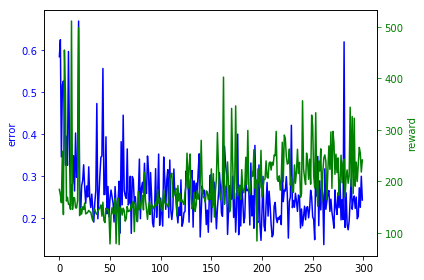

In [13]:

import matplotlib.pyplot as plt
%matplotlib inline

fig, ax1 = plt.subplots()
ax1.plot([e[1] for e in results], 'b-')
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('error', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot([e[2] for e in results], 'g')
ax2.set_ylabel('reward', color='g')
ax2.tick_params('y', colors='g')

fig.tight_layout()
plt.show()


In [14]:
print('''Behavarial cloning for {}.
Expert  policy mean reward {:.2f} and std {:.3f}.
Learned policy mean reward {:.2f} and std {:.3f}.'''.format(
    envname, 
    np.mean([e[0] for e in results][-100:]),
    np.std([e[0] for e in results][-100:]),
    np.mean([e[2] for e in results][-100:]),
    np.std([e[2] for e in results][-100:])
))

Behavarial cloning for Humanoid-v1.
Expert  policy mean reward 10351.12 and std 494.823.
Learned policy mean reward 229.08 and std 42.507.


In [ ]:
args = pd.Series({
        'expert_policy_file':'experts/' + envname + '.pkl',
        'envname': envname,
        'max_timesteps': None,
        'num_rollouts':1,
        'render': True
    })
learn_imitatation_learning(ffn, args)
#evaluate_imitation_learning(ffn, args)

loading and building expert policy
obs (1, 376) (1, 376)
loaded and built
Instructions for updating:
Please use tf.global_variables instead.


[2017-11-03 00:00:16,367] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:91: all_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Please use tf.global_variables instead.


Instructions for updating:
Use `tf.variables_initializer` instead.


[2017-11-03 00:00:16,441] From /home/osminin/shared/GitHub/homework/hw1/tf_util.py:92: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.
[2017-11-03 00:00:18,133] Making new env: Humanoid-v1
